# SD210 TP Bagging and Random Forests

### By Yiting Sun and Yanting LI

#### Math question:
The L classifiers are independent, with the probability of a correct prediction p>0.5, the prediction of the aggregation of the models will be :
$$\binom{L}{k} p^{k}(1-p)^{L-k} $$
Therefore the model follows a Binomial distribution with parameters p and L. 

#### 1)
For p=0.7 and L=10, the probability of correct prediction of the aggregation of model is:

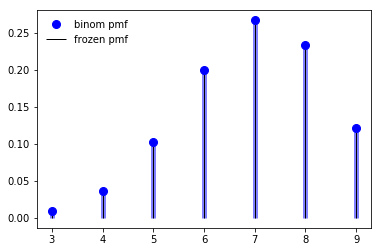

In [141]:
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
L = 10
p = 0.7
mean, var, skew, kurt = binom.stats(L, p, moments='mvsk')
x = np.arange(binom.ppf(0.01, L, p),binom.ppf(0.99, L, p))
ax.plot(x, binom.pmf(x, L, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, binom.pmf(x, L, p), colors='b', lw=5, alpha=0.5)
rv = binom(L, p)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
          label='frozen pmf')
ax.legend(loc='best', frameon=False)
plt.show()

### Part Ⅰ.  Bagging

#### 1)
For question 1), the result gotten by a strump(decision tree of depth 1) is shown below:

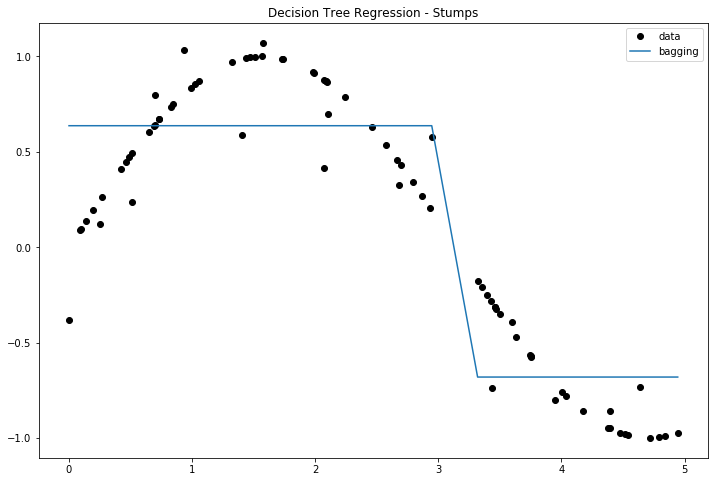

In [4]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
plt.close('all')
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0) #length:80
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))
n_estimators = 10 # L in the text
tree_max_depth = 10
bagging_max_depth = 10

# TODO define the regressor by bagging stumps
tree = DecisionTreeRegressor(max_depth=1)
tree.fit(X, y)
bagging = BaggingRegressor(base_estimator=tree,
                           n_estimators=n_estimators,
                           random_state=rng)
bagging.fit(X, y)

# Predict
y_tree = tree.predict(X)
y_bagging = bagging.predict(X)
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(X, y, 'o', c="k", label="data")
plt.plot(X, y_bagging, label="bagging")
# TODO add plots for Bagging/Tree
plt.title("Decision Tree Regression - Stumps")
plt.legend(loc=1, numpoints=1)
plt.show()

#### 2)
In question 2), the depth of the decision tree is augemented and the results are shown in the first figure; The second figure shows the models with an increasing number of role.

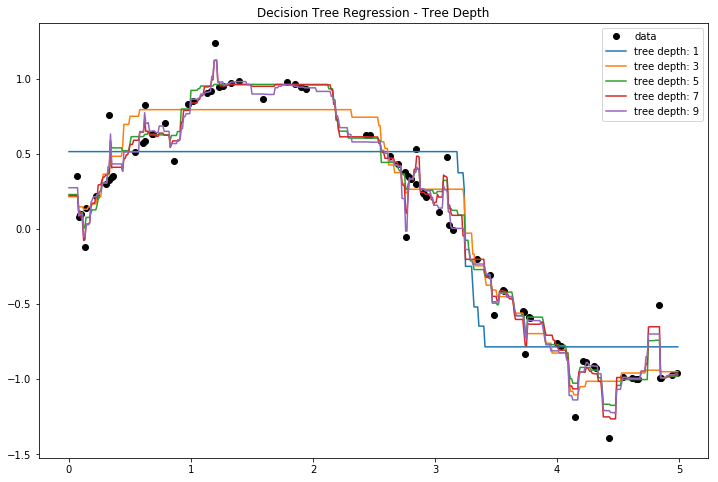

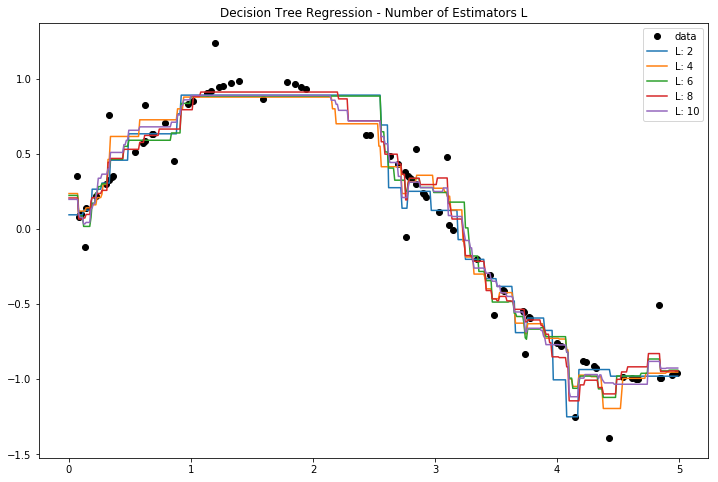

In [10]:
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
# Tree Depth
plt.figure(figsize=(12, 8))
plt.plot(X, y, 'o', c="k", label="data")
# TODO add plots for Bagging/Tree
for depth in range(1,tree_max_depth+1,2):
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X,y)
    bagging = BaggingRegressor(base_estimator=tree,
                               n_estimators=n_estimators,
                               random_state=rng)
    bagging.fit(X,y)
    y_tree = tree.predict(X_test)
    y_bagging = bagging.predict(X_test)
    plt.plot(X_test,y_bagging, label='tree depth: %d'%depth)
plt.title("Decision Tree Regression - Tree Depth")
plt.legend(loc=1, numpoints=1)
plt.show()

# Number of Estimators L
plt.figure(figsize=(12, 8))
plt.plot(X, y, 'o', c="k", label="data")

for L in range(2,bagging_max_depth+1,2):
    tree = DecisionTreeRegressor(max_depth=4)
    tree.fit(X,y)
    bagging = BaggingRegressor(base_estimator=tree,
                               n_estimators=L,
                               random_state=rng)
    bagging.fit(X,y)
    y_tree = tree.predict(X_test)
    y_bagging = bagging.predict(X_test)
    plt.plot(X_test,y_bagging, label='L: %d'%L)
plt.title("Decision Tree Regression - Number of Estimators L")
plt.legend(loc=1, numpoints=1)
plt.show()

#### 3)
To check that the estimators conputed with the decision trees are biased, we repeat the test for 50 times and compute a bias and variance from the result the 50 experiments.

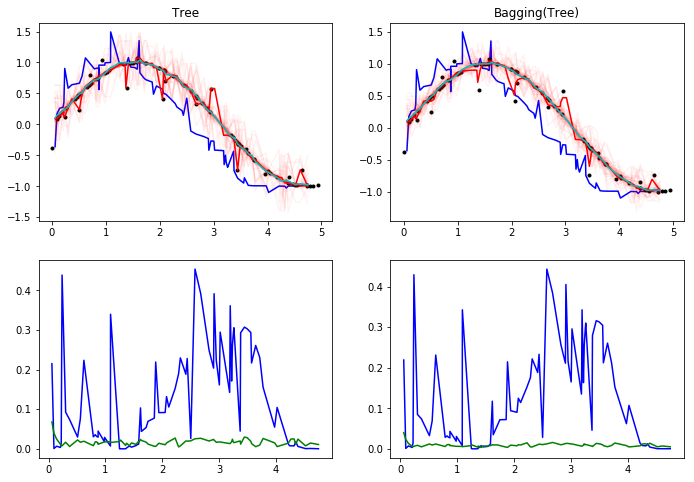

In [121]:
n_repeat = 50
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

X_train = []
y_train = []
for i in range(n_repeat):
    # Generate:
    rng = np.random.RandomState(1+i)
    X = np.sort(5 * rng.rand(80, 1), axis=0) #length:80
    y = np.sin(X).ravel()
    y[::5] += 1 * (0.5 - rng.rand(16))
    
    X_train.append(X)
    y_train.append(y)
# Generate test data
rng = np.random.RandomState(n_repeat+1)
X_test = np.sort(5 * rng.rand(80, 1), axis=0) #length:80
y_test = np.sin(X).ravel()
y_test[::5] += 1 * (0.5 - rng.rand(16))

plt.figure(figsize=(62, 8))
for n, (name, estimator) in enumerate(estimators):
    y_predict =  np.zeros((80, n_repeat))
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)
    y_bias = (y_test - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, y_test, "b", label="test data")
    plt.plot(X_train[0], y_train[0], ".k", label="data")
    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="y_predict")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="predict_mean")
    plt.title(name)
    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_bias, "b", label="bias^2")
    plt.plot(X_test, y_var, "g", label="variance")
plt.show()

From the figure above, the variance of the predicting result gotten from Bagging is obviously lower than the variance gotten from Decision Tree.

#### 4)
In question 4) and 5), we added the noise level to show the over-fitting. For question 4), the argument bootstrap=False, the over-fitting is shown in the figure. For question 5), the argument bootstrap is true by defaut, and the over-fitting is reduced.

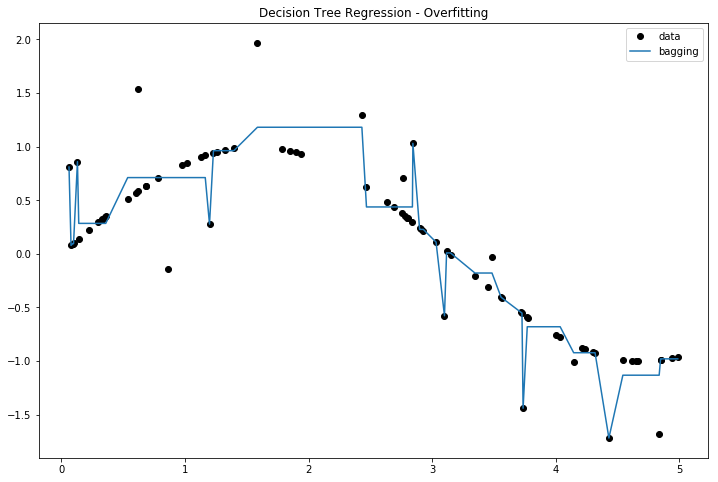

In [7]:
y_over = np.sin(X).ravel()
y_over[::5] += 2 * (0.5 - rng.rand(16))

tree = DecisionTreeRegressor(max_depth = 5)
tree.fit(X,y_over)
bagging = BaggingRegressor(base_estimator=tree,
                           bootstrap=False,
                           random_state=rng)
bagging.fit(X,y_over)
y_over_bagging = bagging.predict(X)
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(X, y_over, 'o', c="k", label="data")
plt.plot(X, y_over_bagging, label="bagging")
# TODO add plots for Bagging/Tree
plt.title("Decision Tree Regression - Overfitting")
plt.legend(loc=1, numpoints=1)
plt.show()

#### 5)

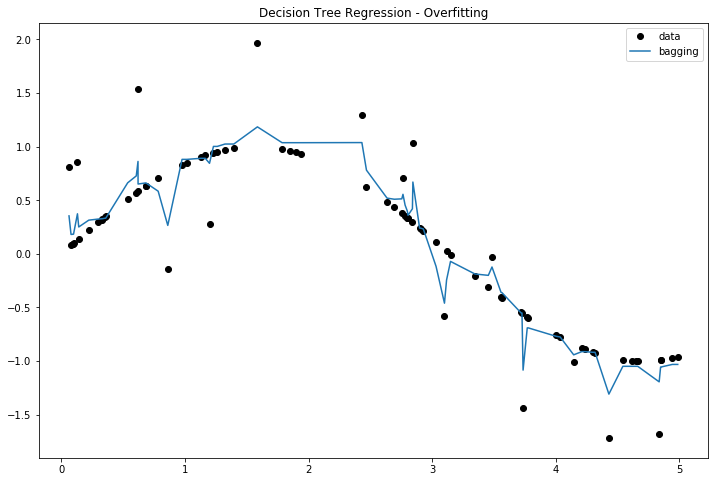

In [8]:
bagging = BaggingRegressor(base_estimator=tree,
                           random_state=rng)
bagging.fit(X,y_over)
y_over_bagging = bagging.predict(X)
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(X, y_over, 'o', c="k", label="data")
plt.plot(X, y_over_bagging, label="bagging")
# TODO add plots for Bagging/Tree
plt.title("Decision Tree Regression - Overfitting")
plt.legend(loc=1, numpoints=1)
plt.show()

### Part Ⅱ. Random Forests

#### 6)
In question 6), for four datasets, the scores of the regressors and the classifiers of random forest and SVM are displayed below: 

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import load_boston, load_diabetes, load_iris, load_digits
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
# boston diabetes iris digits: regression regression classification classification

print 'Data Boston'
boston = load_boston()
X_boston, y_boston = boston.data, boston.target
# Regression - boston - RF
estimator = RandomForestRegressor(n_estimators=10)
score_RFR = cross_val_score(estimator,X_boston,y_boston,cv=7).mean()
print 'score(RFR): ',score_RFR
# Regression - boston - SVM
svr = SVR(kernel='linear')
y_svr = svr.fit(X_boston, y_boston).predict(X_boston)
score_SVM = svr.score(X_boston, y_boston)
print 'Score(SVR): ',score_SVM

print 'Data Diabetes'
diabetes = load_diabetes()
X_diabetes, y_diabetes = diabetes.data, diabetes.target
# Regression - Diabetes - RF
estimator = RandomForestRegressor(n_estimators=10)
score_RFR = cross_val_score(estimator,X_diabetes,y_diabetes,cv=7).mean()
print 'score(RFR): ',score_RFR
# Regression - Diabetes - SVM
svr = SVR(kernel='linear')
y_svr = svr.fit(X_diabetes, y_diabetes).predict(X_diabetes)
score_SVM = svr.score(X_diabetes, y_diabetes)
print 'Score(SVR): ',score_SVM

print 'Data Iris'
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
X_train = X_iris[::2]
y_train = y_iris[::2]
X_test = X_iris[1::2]
y_test = y_iris[1::2]

# Classification - iris - RF
model = RandomForestClassifier(n_estimators=10)
model.fit(X_iris,y_iris)
score_RFC = cross_val_score(model,X_iris,y_iris,cv=7).mean()
print 'score(RFC): ',score_RFC
# Classification - iris - SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score_SVC = clf.score(X_test, y_test)
print 'Score(SVC): ',score_SVC

print 'Data Digits'
digits = load_digits()
X_digits, y_digits = digits.data, digits.target
X_train = X_digits[::2]
y_train = y_digits[::2]
X_test = X_digits[1::2]
y_test = y_digits[1::2]
# Classification - digits - RF
model = RandomForestClassifier(n_estimators=10)
model.fit(X_digits,y_digits)
score_RFC = cross_val_score(model,X_digits,y_digits,cv=7).mean()
print 'score(RFC): ',score_RFC
# Classification - digits - SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score_SVC = clf.score(X_test, y_test)
print 'Score(SVC): ',score_SVC

Data Boston
score(RFR):  0.625443877987
Score(SVR):  0.703426158584
Data Diabetes
score(RFR):  0.349899869117
Score(SVR):  0.00732424756005
Data Iris
score(RFC):  0.946428571429
Score(SVC):  0.973333333333
Data Digits
score(RFC):  0.903158302824
Score(SVC):  0.971046770601


#### 7)
In question 7), we tried two methods: 
- to implement the random forest classifier to generate a figure with all predict result superimposed
- to implement the random forest classifier to generate three figures, each representing the probability of the data to belonging to a class

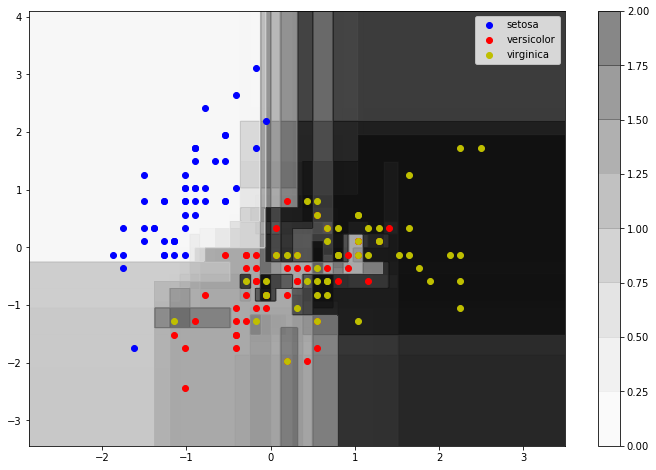

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
# Parameters
n_estimators = 10
plot_colors = "bry"
plot_step = 0.02
# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target

# Standardize
X = preprocessing.scale(X_unscaled)
# RF fitting
model = RandomForestClassifier(n_estimators=n_estimators)
clf = model.fit(X, y)
# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.figure(figsize=(12, 8))
for tree in model.estimators_:
    # TODO use predict to obtain the probabilities you will store in Z
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    # tree.predict_proba returns 3 column, each represent
    # the probability of the corresponding class
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Greys)
plt.colorbar()
plt.axis("tight")
# Plot the training points
for i, c in zip(range(3), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                cmap=plt.cm.Paired)
plt.legend(scatterpoints=1)
plt.show()

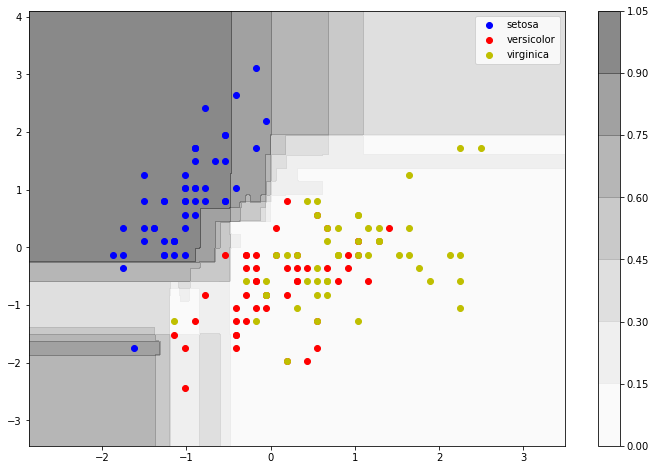

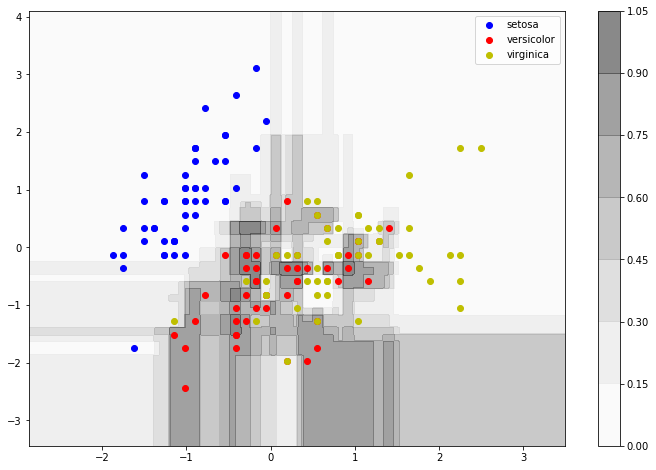

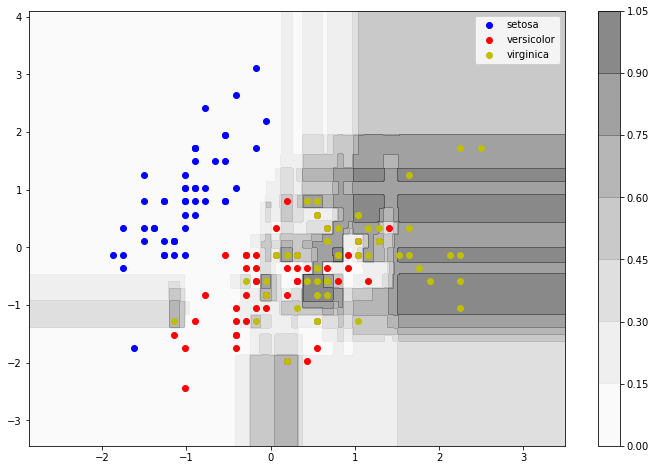

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
# Parameters
n_estimators = 10
plot_colors = "bry"
plot_step = 0.02
# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target[:]

# Standardize
X = preprocessing.scale(X_unscaled)
# RF fitting
model = RandomForestClassifier(n_estimators=n_estimators)
clf = model.fit(X, y)
# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# Forest : Predict_result(samples,trees)
Forest = np.zeros((xx.shape[0]*xx.shape[1],10))
for i,tree in zip(range(10),model.estimators_):
    Forest[:,i] = tree.predict(np.c_[xx.ravel(), yy.ravel()])

Proba = np.zeros((xx.shape[0]*xx.shape[1],3))
Proba_Non = np.zeros((xx.shape[0]*xx.shape[1],3))
for i in range(xx.shape[0]*xx.shape[1]):
    Proba_Non[i][0] = np.count_nonzero(Forest[i])
    Proba_Non[i][1] = np.count_nonzero((Forest-1)[i])
    Proba_Non[i][2] = np.count_nonzero((Forest-2)[i])
Proba = 1 - Proba_Non/10
# print Proba_Non/10
# print Proba.shape

for i in range(3):
    plt.figure(figsize=(12, 8))
    Z = Proba[:,i]
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Greys)
    plt.colorbar()
    plt.axis("tight")
    # Plot the training points
    for i, c in zip(range(3), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                    cmap=plt.cm.Paired)
    plt.legend(scatterpoints=1)
    plt.show()

The three figures above shows the probabilities of belonging to the classes 0,1,2, corresponding to 'setosa','versicolor' and 'virginica' respectively. 
The figures are generated from a random forest which contains 10 decision trees, the probabilities are computed by (the tree numbers which predict class k)/n_estimators

#### 8)
The scores of a Random Forests wi 6-fold cross-validation and a pure decision tree are shown as below:

In [129]:
from sklearn.tree import DecisionTreeClassifier
# RandomForestClassifier for Data iris
iris = load_iris()
X, y = iris.data[:, :2], iris.target
clf_c = RandomForestClassifier(n_estimators=10) 
# 6-Fold Cross validation
score2 =  np.mean(cross_val_score(clf_c, X, y, cv=6))
print 'Score(RFC)',score2

X_train = X[::2]
y_train = y[::2].astype(int)
X_test = X[1::2]
y_test = y[1::2].astype(int)
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print 'Score(Tree)',tree.score(X_test,y_test)

Score(RFC) 0.679783950617
Score(Tree) 0.733333333333


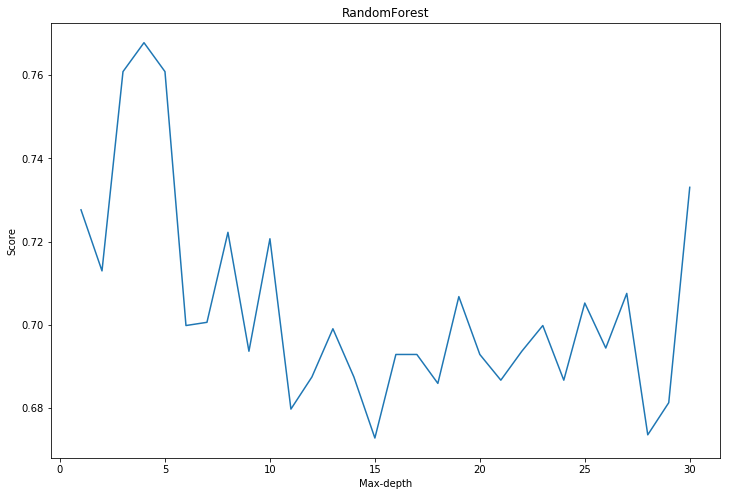

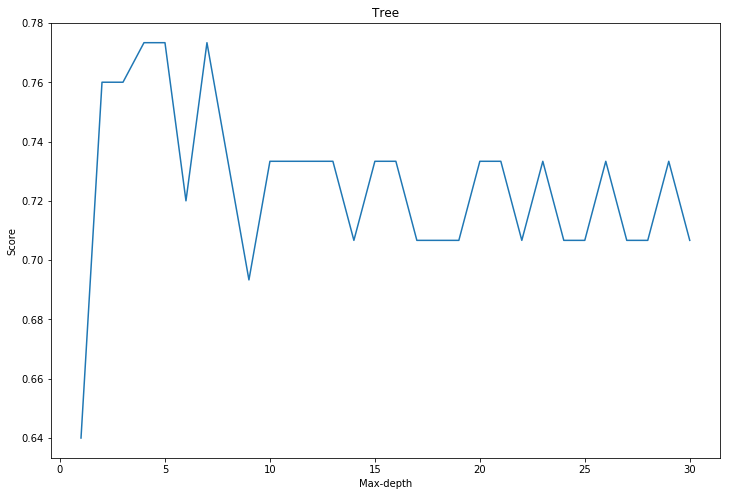

In [131]:
# Vary the parameter max_depth between 1 and 30（RANDOMFOREST）
plt.figure(figsize=(12, 8))
score = []
for i in range(1,31):
    clf_r = RandomForestClassifier(max_depth= i)
    score.append(np.mean(cross_val_score(clf_r, X, y, cv=6)))
plt.title('RandomForest')
plt.xlabel("Max-depth")
plt.ylabel("Score")
plt.plot(range(1,31),score) 
plt.show()

# Vary the parameter max_depth between 1 and 30（TREE）
plt.figure(figsize=(12, 8))
score = []
for i in range(1,31):
    tree = DecisionTreeClassifier(max_depth= i)
    tree.fit(X_train, y_train)
    score.append(tree.score(X_test,y_test))    
plt.title('Tree')    
plt.xlabel("Max-depth")
plt.ylabel("Score")
plt.plot(range(1,31),score) 
plt.show()

With the max_depth vary from 1 to 30, the scores of both RandomForests and deep decision trees are gradually reduced. Therefore, the phenomenon of over-fitting are both shown with these two models.